## Theoretical Challenges for Ocean Dynamics: ice-ocean interactions notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from datetime import datetime, timedelta
import pandas
import csv
from scipy.optimize import fsolve

### 1) Data from the Ronne ice-shelf cavity (site 5)

credit: Keith Nicholls, British Antarctic Survey, UK

#### 1.1) Loading the data from a .mat file array

In [2]:
Depths5 = loadmat('Depths5c.mat') # loading the depths file
Depths5["Depths5c"] # we plot the depths (ice surface used as reference)

array([[ 679.56261513,  698.17693191,  744.71272388,  815.03347618,
         916.37808978, 1029.09811921]])

In [3]:
istart = 12
iend = 9135
AllData = loadmat('s5cInterpAll.mat')
datetimevec = np.array([datetime(year=1, month=1, day=1) + timedelta(days=time-365) for time in AllData['t'][0][istart:iend]])
U1 = np.squeeze(np.array(AllData["s5c"][0]["UV"][0]))[istart:iend]*1e-2 # in cm/s
V1 = np.squeeze(np.array(AllData["s5c"][0]["UV"][1]))[istart:iend]*1e-2
T1 = np.squeeze(np.array(AllData["s5c"][0]["T"][0]))[istart:iend]
S1 = np.squeeze(np.array(AllData["s5c"][0]["S"][0]))[istart:iend]
U2 = np.squeeze(np.array(AllData["s5c"][0]["UV"][4]))[istart:iend]*1e-2
V2 = np.squeeze(np.array(AllData["s5c"][0]["UV"][5]))[istart:iend]*1e-2
T2 = np.squeeze(np.array(AllData["s5c"][0]["T"][4]))[istart:iend]
S2 = np.squeeze(np.array(AllData["s5c"][0]["S"][4]))[istart:iend]
melt = np.squeeze(np.array(AllData["s5c"][0]["melt"][0]))[istart:iend]

#### 1.2) Running a moving average to remove short temporal variability

In [4]:
# 24h moving average operator on hourly data -- no data loss
window_size = 24
weights = np.ones(window_size) / window_size
U1ma = np.convolve(U1, weights, mode='valid')
V1ma = np.convolve(V1, weights, mode='valid')
T1ma = np.convolve(T1, weights, mode='valid')
S1ma = np.convolve(S1, weights, mode='valid')
U2ma = np.convolve(U2, weights, mode='valid')
V2ma = np.convolve(V2, weights, mode='valid')
T2ma = np.convolve(T2, weights, mode='valid')
S2ma = np.convolve(S2, weights, mode='valid')
meltma = np.convolve(melt, weights, mode='valid')
datetimevecma = np.array([datetime(year=1, month=1, day=1) + timedelta(days=time-365) for time in np.convolve(AllData['t'][0][istart:iend], weights, mode='valid')]) 
print(datetimevecma.shape,datetimevec.shape)
print(U1ma.shape,T1ma.shape)

(9100,) (9123,)
(9100,) (9100,)


### 2) Questions
You can answer the questions using the daily averaged data unless mentioned otherwise.

#### 2.1) Show the time history of the measured melt rate (m/y) and compute the mean and standard deviation.

1.0958874889555232 0.5677494528338723


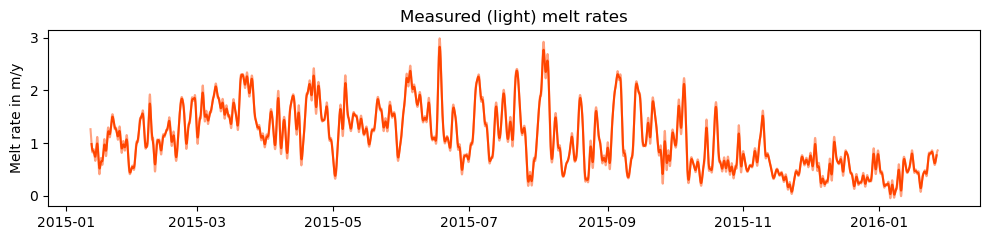

In [5]:
meltmean = meltma.mean()
meltstd = meltma.std()
print(meltmean,meltstd)
fig, ax = plt.subplots(1, 1, figsize=(10,2.5))
ax.plot(datetimevec,melt,color='orangered',alpha=0.5)
ax.plot(datetimevecma,meltma,color='orangered')
ax.set_title("Measured (light) melt rates")
ax.set_ylabel("Melt rate in m/y")
plt.tight_layout()

#### 2.2) Compute the temporal power spectrum of the melt rate without the moving average. Do the same for the V1 and V2 velocities and comment.

3599.999995946884 9123 380.1249995720304


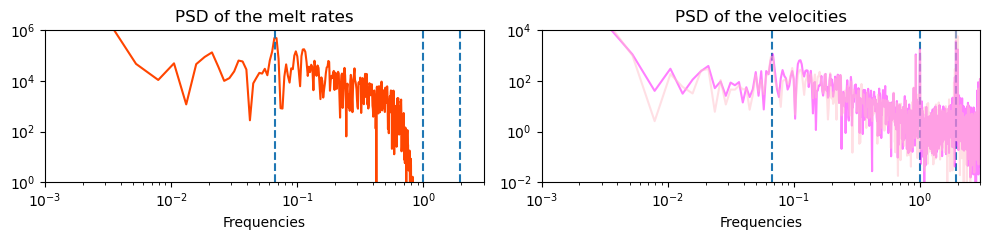

In [6]:
dt_sec = datetimevec[1].timestamp()-datetimevec[0].timestamp()
print(dt_sec,len(melt),len(melt)*dt_sec/3600/24)
coriolis_freq = 1.41e-4 / (2*np.pi)
window = np.hanning(len(melt))
windowed_melt = melt * window
fft_melt = np.fft.rfft(windowed_melt)
fft_U1 = np.fft.rfft(V1 * window)
fft_U2 = np.fft.rfft(V2 * window)
freqs = np.fft.rfftfreq(len(windowed_melt), datetimevec[1].timestamp()-datetimevec[0].timestamp())
fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
ax[0].loglog(freqs*3600*24,np.abs(fft_melt)**2,color='orangered',alpha=1)
[ax[i].axvline(1/15,linestyle='--') for i in range(2)]
[ax[i].axvline(1,linestyle='--') for i in range(2)]
[ax[i].axvline(coriolis_freq*24*3600,linestyle='--') for i in range(2)]
ax[0].set_ylim((1e-0,1e6))
ax[1].set_ylim((1e-2,1e4))
[ax[i].set_xlim((1e-3,3e0)) for i in range(2)]
ax[0].set_title("PSD of the melt rates")
ax[1].set_title("PSD of the velocities")
[ax[i].set_xlabel("Frequencies") for i in range(2)]
ax[1].loglog(freqs*3600*24,np.abs(fft_U1)**2,color='magenta',alpha=0.5)
ax[1].loglog(freqs*3600*24,np.abs(fft_U2)**2,color='pink',alpha=0.5)
plt.tight_layout()

#### 2.3) Show the time history of the temperature and salinity at the two depths (T1,S1 and T2,S2); compute the mean and standard deviation and comment.

-2.316339999642638 -2.2349881370742786
0.036026553634570954 0.026610730585609012
34.51027762004532 34.63222974848037
0.012210699828688144 0.0107852360008905


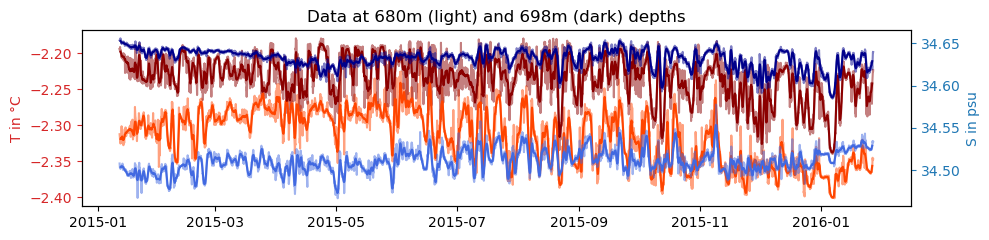

In [7]:
T1mean = T1ma.mean()
T1std = T1ma.std()
S1mean = S1ma.mean()
S1std = S1ma.std()
T2mean = T2ma.mean()
T2std = T2ma.std()
S2mean = S2ma.mean()
S2std = S2ma.std()
print(T1mean,T2mean)
print(T1std,T2std)
print(S1mean,S2mean)
print(S1std,S2std)
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
ax0b = ax.twinx()
ax.plot(datetimevec,T1,color='orangered',alpha=0.5)
ax0b.plot(datetimevec,S1,color='royalblue',alpha=0.5)
ax.plot(datetimevec,T2,color='darkred',alpha=0.5)
ax0b.plot(datetimevec,S2,color='darkblue',alpha=0.5)
ax.plot(datetimevecma,T1ma,color='orangered')
ax0b.plot(datetimevecma,S1ma,color='royalblue')
ax.plot(datetimevecma,T2ma,color='darkred')
ax0b.plot(datetimevecma,S2ma,color='darkblue')
ax.set_title("Data at 680m (light) and 698m (dark) depths")
ax.set_ylabel("T in °C",color='tab:red')
ax0b.set_ylabel("S in psu",color='tab:blue')
ax.tick_params(axis='y', colors='tab:red')
ax0b.tick_params(axis='y', colors='tab:blue')
plt.tight_layout()

#### 2.4) Show the daily-varying melt rate as a function of the T1 temperature. 
Compute the best-fit pre-factor assuming a linear correlation. What are the pre-factor units?

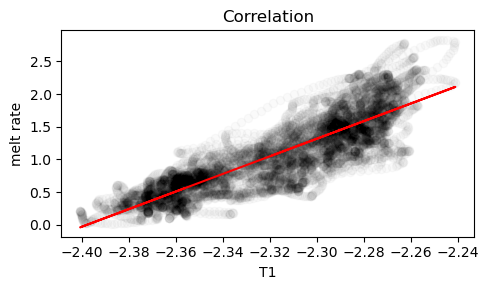

13.457852944187842


In [8]:
linfitcoeff = np.polyfit(T1ma, meltma, 1, rcond=None, full=False, w=None, cov=False)
linfit = linfitcoeff[1] + linfitcoeff[0]*T1ma
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(T1ma,meltma,'ok',alpha=0.02)
ax.plot(T1ma,linfit,'-r')
ax.set_title('Correlation')
ax.set_xlabel('T1')
ax.set_ylabel('melt rate')
plt.tight_layout()
plt.show()
print(linfitcoeff[0])

#### 2.5) Show the daily-varying melt rate as a function of |U1| with |U1| the norm of the horizontal velocity field. 
Compute the best-fit pre-factor assuming a linear correlation. What are the pre-factor units?

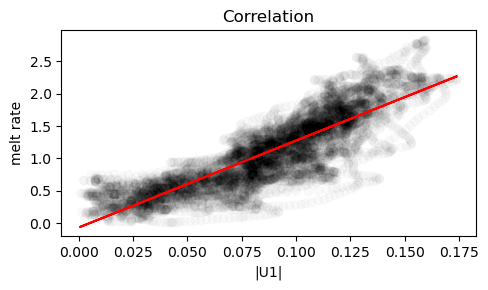

13.398559937558327


In [9]:
U1manorm = np.sqrt(U1ma**2+V1ma**2)
linfitcoeff = np.polyfit(U1manorm, meltma, 1, rcond=None, full=False, w=None, cov=False)
linfit = linfitcoeff[1] + linfitcoeff[0]*U1manorm
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(U1manorm,meltma,'ok',alpha=0.02)
ax.plot(U1manorm,linfit,'-r')
ax.set_title('Correlation')
ax.set_xlabel('|U1|')
ax.set_ylabel('melt rate')
plt.tight_layout()
plt.show()
print(linfitcoeff[0])

#### 2.6) Recall the three boundary conditions that we have at an ice-ocean interface, which are based on the liquidus equation, energy conservation and salt conservation, and how they are parameterized. Considering the parameter values recommended in Jenkins et al (2010) "Observation and Parameterization of Ablation at the Base of Ronne Ice Shelf, Antarctica" (provided below), write a function that can solve the three-equation model for the unknowns  m (your prediction of the melt rate), Tb (basal temperature), and Sb (basal salinity).

In [10]:
Lam1, Lam2, Lam3 = -0.0573, 0.0832, -7.53e-8
ri, rw = 916, 1030
Lf, cw = 3.34e5, 3.974e3
Pb = 916*9.81*731 # in Pa (731 ice thickness for 670)
GAT, GAS, CD = 0.011, 3.1e-4, 0.0097

def threeeq(outputvar,inputvar):
  m, Tb, Sb = outputvar[0], outputvar[1], outputvar[2] # définition des variables
  U, T, S = inputvar[0], inputvar[1], inputvar[2]
  eq1 = Lam1*Sb + Lam2 + Lam3*Pb - Tb
  eq2 = rw*CD**0.5*U*GAS*(S-Sb) - ri*Sb*m
  eq3 = rw*cw*CD**0.5*U*GAT*(T-Tb) - ri*Lf*m
  res = [eq1, eq2, eq3]
  return res
inputvar = [U1manorm[0], T1ma[0], S1ma[0]]
outputvar = [0, 0, 0] # initial guess
fsolve(threeeq, outputvar, inputvar)

array([ 4.43140929e-08, -2.35718728e+00,  3.39574416e+01])

In [11]:
#output = meltma[0]
Tbvec = []; Sbvec = []; mvec = []; sectoyear = 3600*24*365
for i in range(len(T1ma)):
  inputvar = [U1manorm[i], T1ma[i], S1ma[i]]
  solution = fsolve(threeeq, outputvar, inputvar)
  mvec.append(solution[0]*sectoyear)
  Tbvec.append(solution[1])
  Sbvec.append(solution[2])
  outputvar = solution  
mvec = np.stack(mvec)
Tbvec = np.vstack(Tbvec)
Sbvec = np.vstack(Sbvec)

#### 2.7) Plot the results for m (superimposed with the actual melt rate and the predicted melt rate "predmelt" in the dataset), Tb, and Sb and comment.

In [12]:
predmelt = np.squeeze(np.array(AllData["s5c"][0]["predmelt"][0]))[istart:iend]
predmeltma = np.convolve(predmelt, weights, mode='valid')

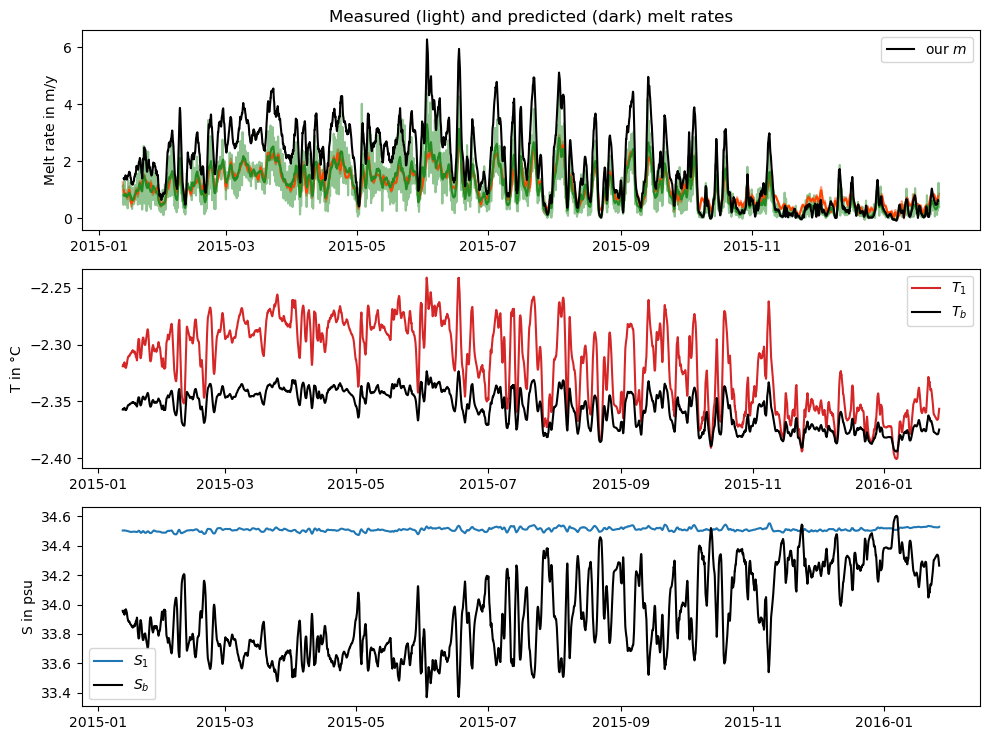

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 7.5))
ax[0].plot(datetimevec,melt,color='orangered',alpha=0.5)
ax[0].plot(datetimevec,predmelt,color='forestgreen',alpha=0.5)
ax[0].plot(datetimevecma,meltma,color='orangered')
ax[0].plot(datetimevecma,predmeltma,color='forestgreen')
ax[0].plot(datetimevecma,mvec,color='black',label=r'our $m$')
ax[0].set_title("Measured (light) and predicted (dark) melt rates")
ax[0].set_ylabel("Melt rate in m/y")
ax[0].legend()
ax[1].plot(datetimevecma,T1ma,color='tab:red',label=r'$T_1$')
ax[2].plot(datetimevecma,S1ma,color='tab:blue',label=r'$S_1$')
ax[1].plot(datetimevecma,Tbvec,color='black',label=r'$T_b$')
ax[2].plot(datetimevecma,Sbvec,color='black',label=r'$S_b$')
ax[1].set_ylabel("T in °C")
ax[2].set_ylabel("S in psu")
ax[1].legend()
ax[2].legend()

plt.tight_layout()

#### 2.8) Is there a set of transport coefficient values that would yield a better agreement between the measured and predicted melt rates? Can you identify it?